<a href="https://colab.research.google.com/github/gaikwadadi/Aditya_Gaikwad_NLP_Task/blob/main/Aditya_Gaikwad_NLP_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Importing Essential Libraries

# --- System & Serialization ---
import os        # For file/directory operations
import pickle    # For saving/loading Python objects

# --- Numerical & Data Handling ---
import numpy as np               # For numerical computations
import pandas as pd              # For data manipulation and analysis
import re                        # For regular expressions (text processing)
import warnings
warnings.filterwarnings('ignore') # To avoid the warnigns

# --- Visualization ---
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For advanced visualizations

# --- TensorFlow & Keras (Deep Learning) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential                           # For building sequential models
from tensorflow.keras.layers import (                                    # Common neural network layers
    Embedding, Bidirectional, GRU, LSTM, Dense, Dropout, LayerNormalization
)
from tensorflow.keras.regularizers import l2                            # For L2 regularization
from tensorflow.keras.optimizers import Adam                            # Optimizer
from tensorflow.keras.callbacks import (                                # Training callbacks
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.preprocessing.text import Tokenizer               # Tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences       # For padding sequences

# --- Scikit-Learn (Classical ML Utilities) ---
from sklearn.preprocessing import LabelEncoder                          # For encoding categorical labels
from sklearn.model_selection import train_test_split, StratifiedKFold   # For train-test splits and cross-validation
from sklearn.utils.class_weight import compute_class_weight             # For handling class imbalance
from sklearn.metrics import (                                           # For model evaluation
    confusion_matrix, classification_report, f1_score
)

In [ ]:
# Download GloVe embeddings if not present

if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    os.system('wget -nc http://nlp.stanford.edu/data/glove.6B.zip')
    os.system('unzip -o glove.6B.zip')

glove_path = './glove.6B.100d.txt'
embedding_dim = 100

#Task 1. Educational Text Classification Model

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2502 - loss: 2.4340 - val_accuracy: 0.2612 - val_loss: 1.9135 - learning_rate: 3.0000e-04
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2710 - loss: 1.8641 - val_accuracy: 0.3491 - val_loss: 1.6244 - learning_rate: 3.0000e-04
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3263 - loss: 1.5791 - val_accuracy: 0.3828 - val_loss: 1.3819 - learning_rate: 3.0000e-04
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3680 - loss: 1.3800 - val_accuracy: 0.3975 - val_loss: 1.2615 - learning_rate: 3.0000e-04
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3851 - loss: 1.2772 - val_accuracy: 0.4172 - val_loss: 1.1994 - learning_rate: 3.0000e-04
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4029 - loss: 1.2239 - val_accuracy: 0.4563 - val_loss: 1.1488 - learning_rate: 3.0000e-04
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0

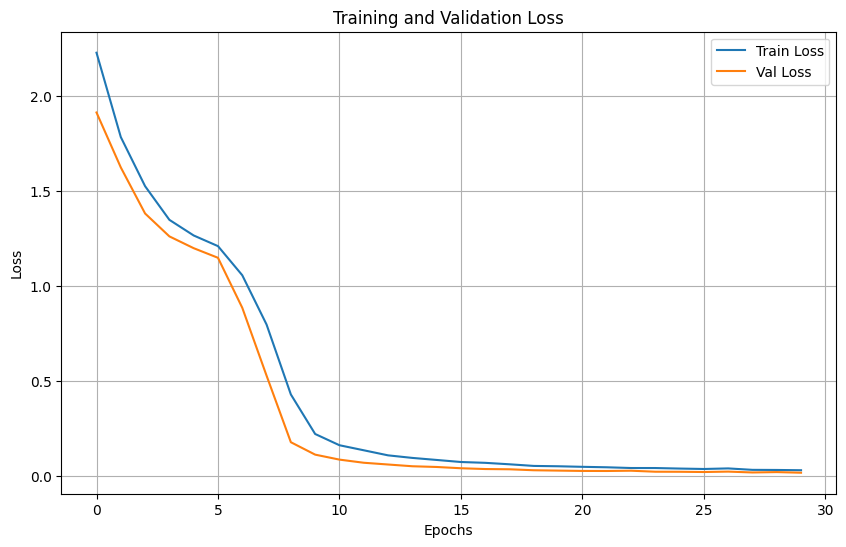

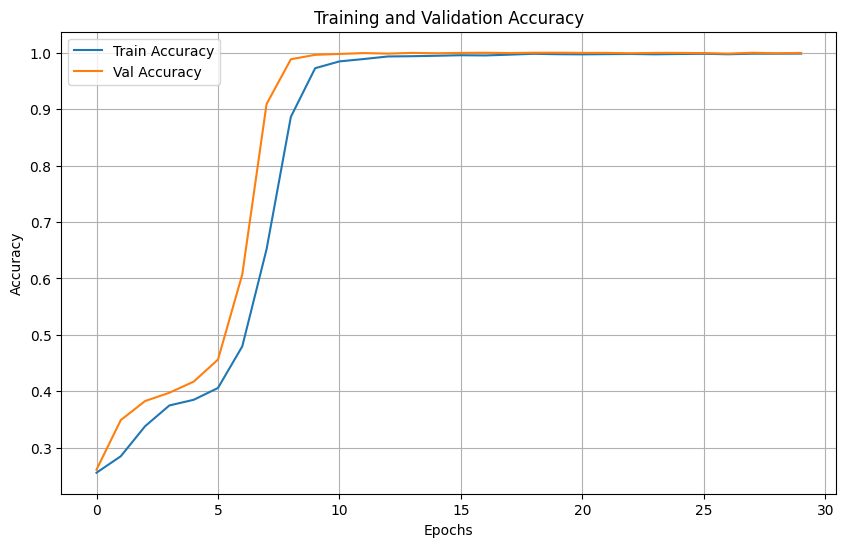


Test Accuracy: 1.0000
Test Loss: 0.0176
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


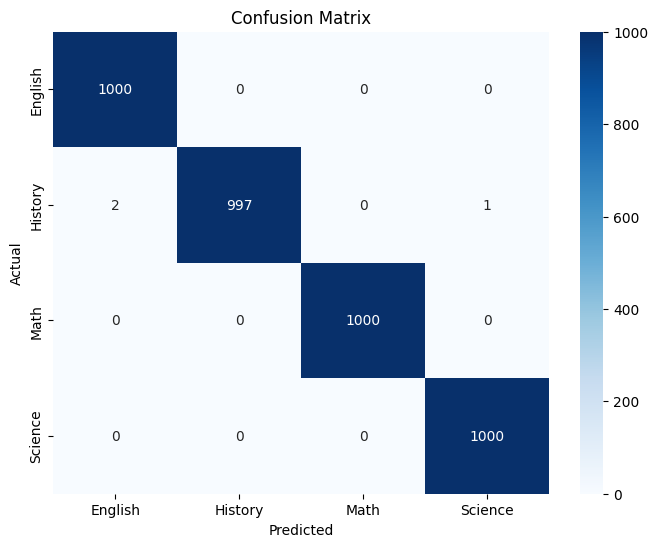


Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00      1000
     History       1.00      1.00      1.00      1000
        Math       1.00      1.00      1.00      1000
     Science       1.00      1.00      1.00      1000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

F1 Score (weighted): 0.9992


In [23]:
# Load dataset
classification_df = pd.read_csv('/content/educational_text_classification.csv')
texts = classification_df[classification_df.columns[0]].values
labels = classification_df['Category'].values

# Label encoding
le = LabelEncoder()
y = le.fit_transform(labels)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Tokenize texts
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Load GloVe embeddings into embedding matrix
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)


# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Prepare one fold for validation using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(X_train, y_train))

X_tr, X_val = X_train[train_idx], X_train[val_idx]
y_tr, y_val = y_train[train_idx], y_train[val_idx]


# Define model architecture
def create_model():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1,
                  output_dim=embedding_dim,
                  input_length=max_len,
                  weights=[embedding_matrix],
                  trainable=False,
                  embeddings_regularizer=l2(1e-4)),
        Bidirectional(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0)),
        LayerNormalization(),
        Bidirectional(GRU(16, dropout=0.5, recurrent_dropout=0)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
        Dropout(0.3),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()


# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Train the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    shuffle=True
)


# Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


# Predictions and Confusion Matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print(f"F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


### Model Testing Using Text

In [25]:
def predict_category(text, model, tokenizer, le, max_len):
    # Tokenize and pad the input
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')

    # Predict
    pred = model.predict(padded_seq)
    pred_label = np.argmax(pred, axis=1)

    # Decode label
    category = le.inverse_transform(pred_label)[0]
    return category


# Example input
sample_text = "The Pythagorean theorem relates the sides of a right triangle."

# Predict category
predicted_category = predict_category(sample_text, model, tokenizer, le, max_len)
print(f"Predicted Category: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Category: Math


#Task 2: Next Word Generation (Auto-completion/Prediction)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 5.3029

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 5.3027 - learning_rate: 0.0020
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 5.1193

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - loss: 5.1216 - learning_rate: 0.0020
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 4.9969

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 5.0000 - learning_rate: 0.0020
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 4.9307

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 4.9380 - learning_rate: 0.0020
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 4.8742

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 4.8818 - learning_rate: 0.0020
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 4.8641

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 4.8673 - learning_rate: 0.0020
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 4.7606

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 4.7685 - learning_rate: 0.0020
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 4.7024

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 4.7075 - learning_rate: 0.0020
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 4.6812

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 4.6811 - learning_rate: 0.0020
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 4.5803

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 4.5818 - learning_rate: 0.0020
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 4.3954

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 4.4032 - learning_rate: 0.0020
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 4.3566

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 4.3626 - learning_rate: 0.0020
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 4.2693

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - loss: 4.2737 - learning_rate: 0.0020
Epoch 14/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 4.2392

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 4.2387 - learning_rate: 0.0020
Epoch 15/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 4.1768

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 4.1750 - learning_rate: 0.0020
Epoch 16/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 4.0174

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 4.0243 - learning_rate: 0.0020
Epoch 17/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.9568

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 3.9634 - learning_rate: 0.0020
Epoch 18/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.9107

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 3.9153 - learning_rate: 0.0020
Epoch 19/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 3.9279

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 3.9264 - learning_rate: 0.0020
Epoch 20/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 3.8051

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 3.8068 - learning_rate: 0.0020
Epoch 21/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 3.7440

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 3.7482 - learning_rate: 0.0020
Epoch 22/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 3.7332

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 3.7373 - learning_rate: 0.0020
Epoch 23/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 3.6964

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 3.6955 - learning_rate: 0.0020
Epoch 24/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 3.5921

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - loss: 3.5967 - learning_rate: 0.0020
Epoch 25/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.4584

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 3.4689 - learning_rate: 0.0020
Epoch 26/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 3.4446

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 3.4489 - learning_rate: 0.0020
Epoch 27/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.3891

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 3.3918 - learning_rate: 0.0020
Epoch 28/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 3.3007

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 3.3052 - learning_rate: 0.0020
Epoch 29/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 3.2586

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 3.2605 - learning_rate: 0.0020
Epoch 30/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 3.1954

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 3.1963 - learning_rate: 0.0020
Epoch 31/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 3.0019

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 3.0126 - learning_rate: 0.0020
Epoch 32/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 3.0559

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 3.0575 - learning_rate: 0.0020
Epoch 33/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 2.9544

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 2.9617 - learning_rate: 0.0020
Epoch 34/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 2.9320

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 2.9343 - learning_rate: 0.0020
Epoch 35/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 2.8788

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 2.8801 - learning_rate: 0.0020
Epoch 36/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.7244

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 2.7330 - learning_rate: 0.0020
Epoch 37/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 2.6602

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 2.6677 - learning_rate: 0.0020
Epoch 38/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 2.5756

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 2.5816 - learning_rate: 0.0020
Epoch 39/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 2.5325

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 2.5378 - learning_rate: 0.0020
Epoch 40/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 2.5013

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 2.5028 - learning_rate: 0.0020
Epoch 41/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.3825

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 2.3885 - learning_rate: 0.0020
Epoch 42/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.3373

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 2.3400 - learning_rate: 0.0020
Epoch 43/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 2.2478

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 2.2509 - learning_rate: 0.0020
Epoch 44/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 2.2008

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 2.2005 - learning_rate: 0.0020
Epoch 45/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.0888

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 2.0942 - learning_rate: 0.0020
Epoch 46/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 2.0783

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - loss: 2.0750 - learning_rate: 0.0020
Epoch 47/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 1.9702

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 1.9731 - learning_rate: 0.0020
Epoch 48/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.9151

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 1.9159 - learning_rate: 0.0020
Epoch 49/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 1.8001

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 1.8053 - learning_rate: 0.0020
Epoch 50/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.7982

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 1.8012 - learning_rate: 0.0020
Epoch 51/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 1.6766

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 1.6845 - learning_rate: 0.0020
Epoch 52/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.6769

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 1.6781 - learning_rate: 0.0020
Epoch 53/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1.6463

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 1.6459 - learning_rate: 0.0020
Epoch 54/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.5229

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 1.5277 - learning_rate: 0.0020
Epoch 55/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.4800

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 1.4841 - learning_rate: 0.0020
Epoch 56/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.4537

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 1.4552 - learning_rate: 0.0020
Epoch 57/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 1.4123

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 1.4128 - learning_rate: 0.0020
Epoch 58/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.2792

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 1.2879 - learning_rate: 0.0020
Epoch 59/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 1.2782

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 1.2805 - learning_rate: 0.0020
Epoch 60/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1.2466

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 1.2471 - learning_rate: 0.0020
Epoch 61/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.1640

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 1.1695 - learning_rate: 0.0020
Epoch 62/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.2046

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 1.2015 - learning_rate: 0.0020
Epoch 63/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.1186

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 1.1209 - learning_rate: 0.0020
Epoch 64/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 1.0563

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 1.0594 - learning_rate: 0.0020
Epoch 65/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 1.0812

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 1.0799 - learning_rate: 0.0020
Epoch 66/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.9933

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.9958 - learning_rate: 0.0020
Epoch 67/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.9343

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.9375 - learning_rate: 0.0020
Epoch 68/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.8974

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.9011 - learning_rate: 0.0020
Epoch 69/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.8790

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.8805 - learning_rate: 0.0020
Epoch 70/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.9076

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.9054 - learning_rate: 0.0020
Epoch 71/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.7901

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.7956 - learning_rate: 0.0020
Epoch 72/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.7783

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.7812 - learning_rate: 0.0020
Epoch 73/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.7554

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.7579 - learning_rate: 0.0020
Epoch 74/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.7564

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.7560 - learning_rate: 0.0020
Epoch 75/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.7027

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.7035 - learning_rate: 0.0020
Epoch 76/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.6633

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.6652 - learning_rate: 0.0020
Epoch 77/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.6260

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.6281 - learning_rate: 0.0020
Epoch 78/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.6352

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.6349 - learning_rate: 0.0020
Epoch 79/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.5946

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.5957 - learning_rate: 0.0020
Epoch 80/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.5743

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.5751 - learning_rate: 0.0020
Epoch 81/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.5666

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.5661 - learning_rate: 0.0020
Epoch 82/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.5257

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.5268 - learning_rate: 0.0020
Epoch 83/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.5277

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.5264 - learning_rate: 0.0020
Epoch 84/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.4945

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - loss: 0.4939 - learning_rate: 0.0020
Epoch 85/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.4448

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.4475 - learning_rate: 0.0020
Epoch 86/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.4447

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.4458 - learning_rate: 0.0020
Epoch 87/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.4242

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.4262 - learning_rate: 0.0020
Epoch 88/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.4132

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.4142 - learning_rate: 0.0020
Epoch 89/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.4098

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.4094 - learning_rate: 0.0020
Epoch 90/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.3895

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 0.3889 - learning_rate: 0.0020
Epoch 91/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3915

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.3907 - learning_rate: 0.0020
Epoch 92/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3682

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.3681 - learning_rate: 0.0020
Epoch 93/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3272

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.3298 - learning_rate: 0.0020
Epoch 94/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.3439

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.3437 - learning_rate: 0.0020
Epoch 95/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.3011

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.3035 - learning_rate: 0.0020
Epoch 96/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - loss: 0.3302 - learning_rate: 0.0020
Epoch 97/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.3179

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.3176 - learning_rate: 0.0020
Epoch 98/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2853

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.2871 - learning_rate: 0.0020
Epoch 99/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2815

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.2819 - learning_rate: 0.0020
Epoch 100/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.2927

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.2904 - learning_rate: 0.0020
Epoch 101/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2811

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.2797 - learning_rate: 0.0020
Epoch 102/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.2545

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - loss: 0.2541 - learning_rate: 0.0020
Epoch 103/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2438

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.2435 - learning_rate: 0.0020
Epoch 104/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2477

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.2469 - learning_rate: 0.0020
Epoch 105/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2227

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.2234 - learning_rate: 0.0020
Epoch 106/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2244

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.2244 - learning_rate: 0.0020
Epoch 107/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1994

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.2005 - learning_rate: 0.0020
Epoch 108/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.2121 - learning_rate: 0.0020
Epoch 109/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.2270

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.2251 - learning_rate: 0.0020
Epoch 110/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1867

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.1881 - learning_rate: 0.0020
Epoch 111/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.2154 - learning_rate: 0.0020
Epoch 112/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2004

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.2003 - learning_rate: 0.0020
Epoch 113/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1981

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 0.1976 - learning_rate: 0.0020
Epoch 114/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.1729

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.1741 - learning_rate: 0.0020
Epoch 115/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1792

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1790 - learning_rate: 0.0020
Epoch 116/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1645

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1653 - learning_rate: 0.0020
Epoch 117/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1740

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.1736 - learning_rate: 0.0020
Epoch 118/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1595

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.1604 - learning_rate: 0.0020
Epoch 119/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.1389

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.1404 - learning_rate: 0.0020
Epoch 120/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1518

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - loss: 0.1518 - learning_rate: 0.0020
Epoch 121/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1469

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 0.1470 - learning_rate: 0.0020
Epoch 122/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1366

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.1372 - learning_rate: 0.0020
Epoch 123/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.1449 - learning_rate: 0.0020
Epoch 124/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1323

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.1331 - learning_rate: 0.0020
Epoch 125/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1421

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.1418 - learning_rate: 0.0020
Epoch 126/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1459

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1449 - learning_rate: 0.0020
Epoch 127/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1323

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1322 - learning_rate: 0.0020
Epoch 128/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1277

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.1273 - learning_rate: 0.0020
Epoch 129/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1173

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.1177 - learning_rate: 0.0020
Epoch 130/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.1072

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - loss: 0.1080 - learning_rate: 0.0020
Epoch 131/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1093

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.1099 - learning_rate: 0.0020
Epoch 132/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.1200 - learning_rate: 0.0020
Epoch 133/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1075

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.1077 - learning_rate: 0.0020
Epoch 134/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0979

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0989 - learning_rate: 0.0020
Epoch 135/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1045

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - loss: 0.1042 - learning_rate: 0.0020
Epoch 136/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0953

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 0.0957 - learning_rate: 0.0020
Epoch 137/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0959 - learning_rate: 0.0020
Epoch 138/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0953

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0956 - learning_rate: 0.0020
Epoch 139/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0954

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 0.0957 - learning_rate: 0.0020
Epoch 140/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0891

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.0897 - learning_rate: 0.0020
Epoch 141/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0904

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0902 - learning_rate: 0.0020
Epoch 142/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0807 - learning_rate: 0.0020
Epoch 143/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0911 - learning_rate: 0.0020
Epoch 144/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.0820

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - loss: 0.0823 - learning_rate: 0.0020
Epoch 145/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0861

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.0860 - learning_rate: 0.0020
Epoch 146/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0768

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0776 - learning_rate: 0.0020
Epoch 147/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0870

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0864 - learning_rate: 0.0020
Epoch 148/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0698

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 0.0707 - learning_rate: 0.0020
Epoch 149/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - loss: 0.0806 - learning_rate: 0.0020
Epoch 150/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0696

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0705 - learning_rate: 0.0020
Epoch 151/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0844

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0834 - learning_rate: 0.0020
Epoch 152/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0812

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.0803 - learning_rate: 0.0020
Epoch 153/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0695

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0694 - learning_rate: 0.0020
Epoch 154/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0648 - learning_rate: 0.0020
Epoch 155/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0743 - learning_rate: 0.0020
Epoch 156/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0691 - learning_rate: 0.0020
Epoch 157/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0682

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.0679 - learning_rate: 0.0010
Epoch 158/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0634 - learning_rate: 0.0010
Epoch 159/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0539

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0546 - learning_rate: 0.0010
Epoch 160/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.0601 - learning_rate: 0.0010
Epoch 161/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0556

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0561 - learning_rate: 0.0010
Epoch 162/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0638 - learning_rate: 0.0010
Epoch 163/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0573

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0574 - learning_rate: 0.0010
Epoch 164/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0596 - learning_rate: 0.0010
Epoch 165/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0581 - learning_rate: 0.0010
Epoch 166/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - loss: 0.0596 - learning_rate: 0.0010
Epoch 167/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.0612 - learning_rate: 5.0000e-04
Epoch 168/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0541

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0543 - learning_rate: 5.0000e-04
Epoch 169/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0557 - learning_rate: 5.0000e-04
Epoch 170/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0562 - learning_rate: 5.0000e-04
Epoch 171/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.0618 - learning_rate: 5.0000e-04
Epoch 172/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.0515 - learning_rate: 2.5000e-04
Epoch 173/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0516

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0519 - learning_rate: 2.5000e-04
Epoch 174/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0561 - learning_rate: 2.5000e-04
Epoch 175/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0565 - learning_rate: 2.5000e-04
Epoch 176/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.0554 - learning_rate: 2.5000e-04
Epoch 177/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0568 - learning_rate: 1.2500e-04
Epoch 178/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0531

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0531 - learning_rate: 1.2500e-04
Epoch 179/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0467

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0472 - learning_rate: 1.2500e-04
Epoch 180/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0534 - learning_rate: 1.2500e-04
Epoch 181/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0494 - learning_rate: 1.2500e-04
Epoch 182/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0536 - learning_rate: 1.2500e-04
Epoch 183/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - loss: 0.0547 - learning_rate: 6.2500e-05
Epoch 184/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0499 - learning_rate: 6.2500e-05
Epoch 185/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0613 - learning_rate: 6.2500e-05
Epoch 186/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0507

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0507 - learning_rate: 3.1250e-05
Epoch 187/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0503 - learning_rate: 3.1250e-05
Epoch 188/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - loss: 0.0533 - learning_rate: 3.1250e-05
Epoch 189/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0635 - learning_rate: 3.1250e-05
Epoch 190/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0504 - learning_rate: 1.5625e-05
Epoch 191/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0529 - learning_rate: 1.5625e-05
Epoch 192/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0515 - learning_rate: 1.5625e-05
Epoch 193/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0536 - learning_rate: 1.0000e-05
Epoch 194/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.0559 - learning_rate: 1.0000e-05
Epoch 195/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0576 - learning_rate: 1.0000e-05
Epoch 196/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step -

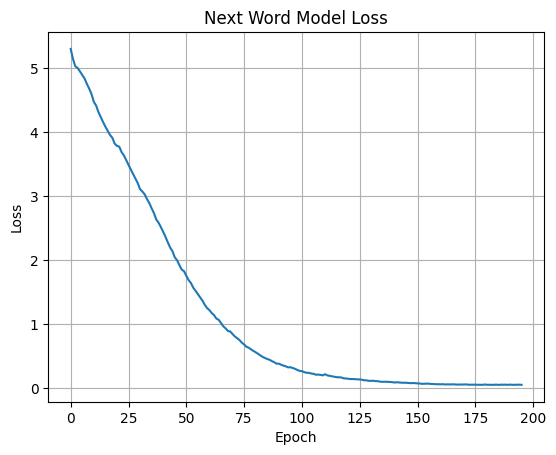

In [16]:
# ------------------------------
# LOAD AND PREPROCESS DATA
# ------------------------------
with open('/content/large_next_word_generation_corpus.txt', 'r') as file:
    generation_data = file.read().lower()

# Use regex to split into sentences (avoid nltk issues)
sentences = re.split(r'(?<=[.!?]) +', generation_data)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

# Tokenizer fit on sentences
gen_tokenizer = Tokenizer()
gen_tokenizer.fit_on_texts(sentences)
total_words = len(gen_tokenizer.word_index) + 1

# Create input sequences of increasing length for next word prediction
input_sequences = []
for line in sentences:
    tokens = gen_tokenizer.texts_to_sequences([line])[0]
    if len(tokens) > 1:
        for i in range(1, len(tokens)):
            input_sequences.append(tokens[:i+1])

max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

X_gen = input_sequences[:, :-1]
y_gen = input_sequences[:, -1]

# ------------------------------
# DEFINE MODEL
# ------------------------------
gen_model = Sequential([
    Embedding(total_words, 128, input_length=max_seq_len-1),
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(total_words, activation='softmax')
])

gen_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.002))

# ------------------------------
# CALLBACKS
# ------------------------------
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_next_word_model.h5', save_best_only=True, monitor='loss')

# ------------------------------
# TRAIN MODEL
# ------------------------------
hist_gen = gen_model.fit(
    X_gen, y_gen,
    epochs=200,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)

# ------------------------------
# PLOT LOSS
# ------------------------------
plt.plot(hist_gen.history['loss'])
plt.title('Next Word Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ------------------------------
# PREPARE INDEX TO WORD MAPPING
# ------------------------------
index_word = {v: k for k, v in gen_tokenizer.word_index.items()}
index_word[0] = ''  # padding token

# ------------------------------
# TEXT GENERATION FUNCTION
# ------------------------------
def generate_text(seed_text, next_words, temperature=1.0, top_k=10):
    result = seed_text
    for _ in range(next_words):
        token_list = gen_tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        preds = gen_model.predict(token_list, verbose=0)[0]
        preds = np.log(preds + 1e-9) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        top_k_idx = np.argsort(preds)[-top_k:]
        top_k_probs = preds[top_k_idx]
        top_k_probs /= top_k_probs.sum()

        predicted_word_idx = np.random.choice(top_k_idx, p=top_k_probs)
        predicted_word = index_word.get(predicted_word_idx, '')
        result += ' ' + predicted_word
    return result.strip()


# Text Generation Using Model

In [17]:
# Example generation
print(generate_text("mathematics is the study of", 20, temperature=0.7))

mathematics is the study of symbols and the rules for manipulating those symbols and culture and cultural a bridges all these creating opportunities for interdisciplinary
